In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import torchvision
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [169]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
import mushroom.visualization.helpers as helpers
from mushroom.mushroom import Mushroom

In [469]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
output_dir = project_dir / 'analysis' / 'region_characterization'
output_dir.mkdir(parents=True, exist_ok=True)

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [7]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps = [fp for fp in fps if fp.split('/')[-3] in case_order]
fps

['/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-9906/mushroom_50res/config.yaml']

In [12]:
case_to_config = {fp.split('/')[-3]:yaml.safe_load(open(fp)) for fp in fps}
case_to_config.keys()

dict_keys(['HT206B1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT565B1-H2', 'HT704B1', 'HT891Z1', 'HT913Z1', 'S18-5591-C8', 'S18-9906'])

In [ ]:
multiplex_mapping = {
    'keratin-5': 'ck5',
    'keratin-14': 'ck14',
}
pattern = r'[ -]?\(?[dD]\)?$'
def alter_name(x):
    x = re.sub(pattern, '', x)
    x = x.lower()
    x = x.replace(' ', '-')
    x = multiplex_mapping.get(x, x)
    return x

In [276]:
def generate_labeled_regions(x, cut=10, area=10):
    mask = x > cut
    # mask = skimage.filters.gaussian(x, sigma=.5)
    # mask = mask > .1
    plt.imshow(mask)
    plt.show()

    mask = scipy.ndimage.binary_fill_holes(mask)

    labeled = skimage.morphology.label(mask)

    props = skimage.measure.regionprops(labeled)
    for p in props:
        if p.area < 10:
            labeled[labeled==p.label] = 0
    
    return labeled

def get_feature_df(labeled, img, channels, channel_info):
    annots = sorted(channel_info.keys())
    data = []
    columns =  channels + annots
    props = skimage.measure.regionprops(labeled, intensity_image=rearrange(img, 'c h w -> h w c'))
    for p in props:
        row = list(p.intensity_mean)
        r1, c1, r2, c2 = p.bbox
        for annot in annots:
            tile = annot_to_mask[annot][r1:r2, c1:c2]
            frac = np.count_nonzero(tile[p.image] > 0) / np.count_nonzero(p.image)
            row.append(frac)
        data.append(row)
    return pd.DataFrame(data=data, columns=columns, index=[p.label for p in props])

In [448]:
case_to_channel_info = {
    'HT206B1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 5),
            'myoepithelial': ('ACTA2', 5),
        },
        'xenium_1': {
            'epithelial': ('EPCAM', 5),
            'myoepithelial': ('ACTA2', 5),
        },
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('sma', 40),
        },
        'multiplex_1': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('sma', 40),
        }
    },
    'HT704B1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 5),
            'myoepithelial': ('KRT5', 5),
        },
        'cosmx_0': {
            'epithelial': ('EPCAM', 5),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck5', 40),
        }
    },
    'HT397B1': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        },
        'multiplex_1': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        },
        'multiplex_2': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        }
    },
    'HT339B2-H1': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 5),
            'myoepithelial': ('ck5', 40),
        }
    },
    'HT565B1-H2': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck5', 40),
        }
    },
    'HT891Z1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 15),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 55),
            'myoepithelial': ('ck5', 40),
        },
        'vishd_0': {
            'epithelial': ('EPCAM', 15),
            'myoepithelial': ('KRT5', 5),
        },
    },
    'HT913Z1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 15),
            'myoepithelial': ('TP63', 5),
        },
        'xenium_1': {
            'epithelial': ('EPCAM', 14),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 100),
            'myoepithelial': ('ck5', 40),
        }
    },
    'S18-5591-C8': {
        'xenium_0': {
            'epithelial': ('EPCAM', 5),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 3),
            'myoepithelial': ('ck5', 40),
        }
    },
    'S18-9906': {
        'xenium_0': {
            'epithelial': ('EPCAM', 15),
            'myoepithelial': ('KRT7', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 30),
            'myoepithelial': ('ck5', 40),
        }
    },
    
        
}

In [432]:
for case in cases:
    imaris_dir = project_dir / case / 'imaris' / 'rois'
    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)
    
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    dtype_ident_to_channels = meta['dtype_ident_to_channels']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    tiling_size = meta['tiling_size']
    size = meta['size']
    fullres_size = meta['fullres_size']
    dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']
    
    dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
    for dti, tiled in dtype_ident_to_tiled.items():
        print(dti, tiled.shape)
    
    sid_to_tiled_idx = {}
    for dtype_ident in dtype_ident_to_channels.keys():
        if 'vis' not in dtype_ident:
            dtype = dtype_ident_to_dtype[dtype_ident]
            sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
            for i, sid in enumerate(sids):
                sid_to_tiled_idx[sid] = i

    for entry in config['sections']:
        sid = entry['sid']
        position = entry['position']
        dti = sid_to_dtype_ident[sid]
        dtype = dti.split('_')[0]
        channels = dtype_ident_to_channels[dti]

        if dtype == 'multiplex':
            channels = [alter_name(x) for x in channels]

        if dti in dtype_ident_to_tiled:
            img = dtype_ident_to_tiled[dti][sid_to_tiled_idx[sid]]
            channel, cut = case_to_channel_info[case][dti]['epithelial']
    
            labeled = generate_labeled_regions(img, cut)
            channel_info = case_to_channel_info[case][dti]

            expanded = skimage.segmentation.expand_labels(labeled, distance=2)
            m = (expanded > 0) & ~(labeled > 0)
            ring = expanded.copy()
            ring[~m] = 0
            
            expanded = skimage.segmentation.expand_labels(labeled, distance=10)
            m = (expanded > 0) & ~(labeled > 0)
            tme = expanded.copy()
            tme[~m] = 0
            
            annot_to_mask = {
                k: img[channels.index(info[0])] > info[1] for k, info in channel_info.items()
            }
            
            stack = []
            for name, x in zip(['region', 'boundary', 'tme'], [labeled, ring, tme]):
                df = get_feature_df(x, img, channels, channel_info)
                df.columns = [f'{name}_{c}' for c in df.columns]
                stack.append(df)
            df = pd.concat(stack, axis=1)
        elif dti == 'vishd_0':
            fp = sid_to_pred_multiplex[sid]
            img = tifffile.imread(fp)
            
            

        tifffile.imwrite(output_dir / f'{sid}_regions.tif', labeled, compression='LZW')
        tifffile.imwrite(output_dir / f'{sid}_boundaries.tif', ring, compression='LZW')
        tifffile.imwrite(output_dir / f'{sid}_tme.tif', tme, compression='LZW')
            
        df.to_csv(output_dir / f'{sid}_regions.txt', sep='\t')
        

In [436]:
case = 'HT891Z1'
imaris_dir = project_dir / case / 'imaris' / 'rois'
config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
config = alter_filesystem(config, source_root, target_root)

meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))

sid_to_channels = meta['sid_to_channels']
dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
dtype_ident_to_channels = meta['dtype_ident_to_channels']
sid_to_dtype_ident = meta['sid_to_dtype_ident']
tiling_size = meta['tiling_size']
size = meta['size']
fullres_size = meta['fullres_size']
dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']

dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
for dti, tiled in dtype_ident_to_tiled.items():
    print(dti, tiled.shape)

sid_to_tiled_idx = {}
for dtype_ident in dtype_ident_to_channels.keys():
    if 'vis' not in dtype_ident:
        dtype = dtype_ident_to_dtype[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
        for i, sid in enumerate(sids):
            sid_to_tiled_idx[sid] = i

xenium_0 (9, 476, 653, 725)
he_0 (25, 3, 653, 725)
multiplex_0 (16, 25, 653, 725)


In [450]:
dti = 'vishd_0'
fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/HT891Z1-U2_visiumhd.h5ad'
adata = sc.read_h5ad(fp)
adata.var_names_make_unique()

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [441]:
adata.obs

,y_location,x_location
s_002um_00775_02414-1,1359.0,5325.0
s_002um_00700_02130-1,1917.0,5521.0
s_002um_01790_02283-1,1741.0,3276.0
s_002um_02058_00301-1,5716.0,2968.0
s_002um_02278_00850-1,4649.0,2448.0
...,...,...
s_002um_02189_01783-1,2784.0,2525.0
s_002um_01609_01578-1,3124.0,3741.0
s_002um_02448_01644-1,3090.0,2011.0
s_002um_02703_00756-1,4883.0,1579.0


In [465]:
img = np.zeros(size)
channel, cut = case_to_channel_info[case][dti]['epithelial']
channel = 'KRT5'

In [466]:
scale = 1 / tiling_size 
ys = (adata.obs['y_location'] * scale).astype(int)
xs = (adata.obs['x_location'] * scale).astype(int)

In [467]:
img[ys, xs] = adata[:, channel].X.toarray().flatten()

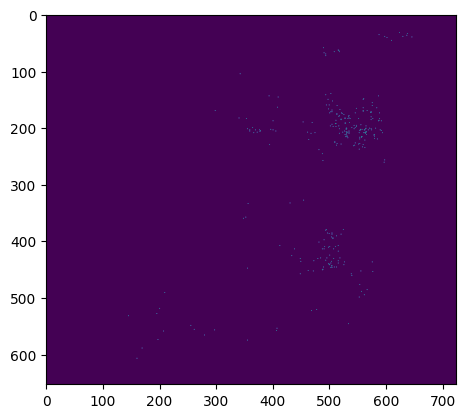

In [468]:
plt.imshow(img>0)

In [ ]:
# just piggy backing visium off this too
sid_to_vishd_roi_adata = {}
for sid, fp in sid_to_fp.items():
    if sid_to_dtype[sid] in ['vishd', 'visium']:
        fp = sid_to_fp[sid]
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = sid_to_channels[sid]
        adata = adata[:, channels]
        adata.obs['tmp'] = 0 # need to initialize view for some reason
        

        if sid_to_dtype[sid] == 'visium': # put coordinates in same spot as hd
            adata.obs['y_location'] = adata.obsm['spatial'][:, 1]
            adata.obs['x_location'] = adata.obsm['spatial'][:, 0]
        
        m = adata.obs['y_location'] >= R1
        m &= adata.obs['y_location'] < R2
        m &= adata.obs['x_location'] >= C1
        m &= adata.obs['x_location'] < C2
        adata = adata[m]
        adata.obs['y_location'] -= R1
        adata.obs['x_location'] -= C1
        sid_to_vishd_roi_adata[sid] = adata
sid_to_vishd_roi_adata.keys()     

epithelial


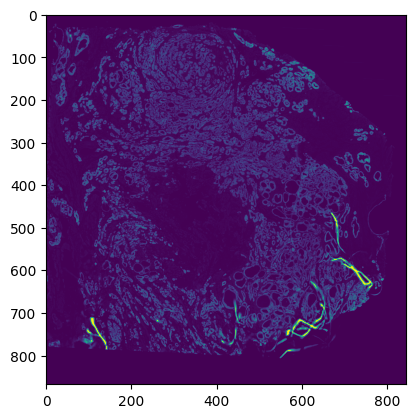

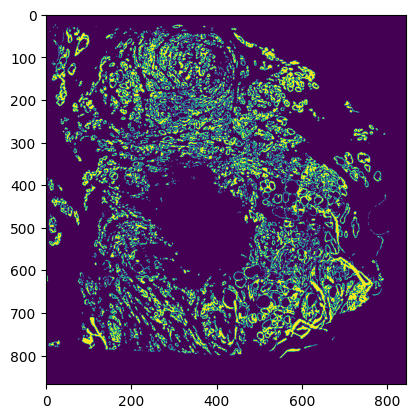

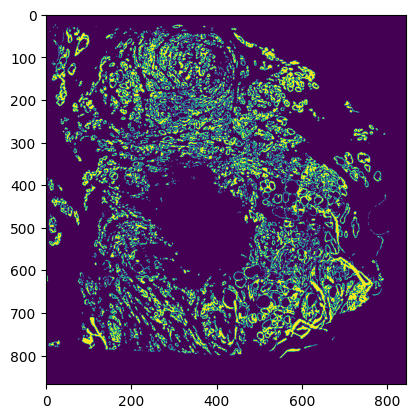

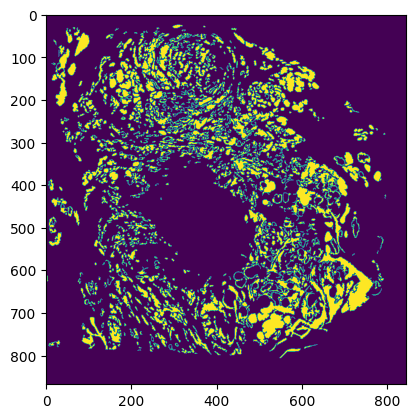

myoepithelial


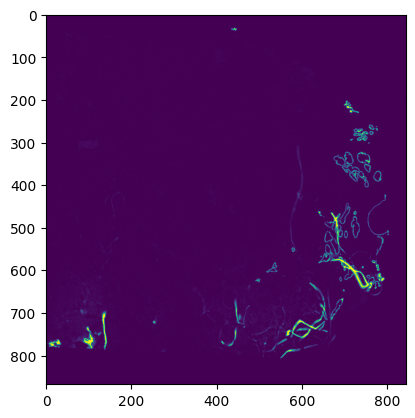

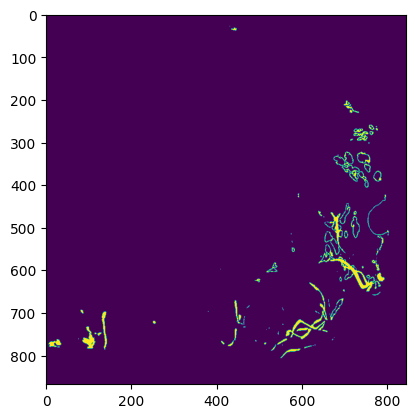

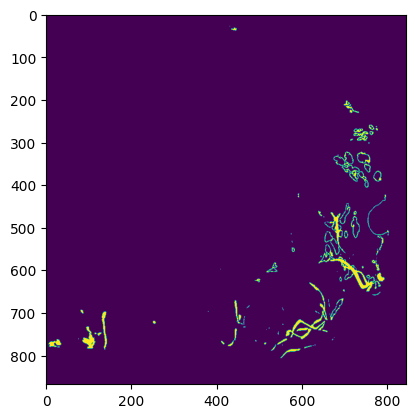

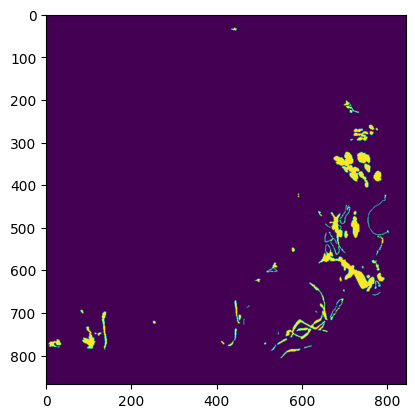

In [435]:
# # dti = 'xenium_0'
# dti = 'multiplex_0'
# # dti = 'cosmx_0'
# # dtype = dti.split('_')[0]
# # channel, cut = case_to_channel_info[case][dtype]['epithelial']
# channels = dtype_ident_to_channels[dti]

# if 'multiplex' in dti:
#     channels = [alter_name(x) for x in channels]

# for k, v in case_to_channel_info[case][dti].items():
#     print(k)
#     channel, cut = v
    
#     idx = channels.index(channel)
#     x = dtype_ident_to_tiled[dti][0, idx]
#     plt.imshow(x)
#     plt.show()

#     plt.imshow(x > cut)
#     plt.show()

#     labeled = generate_labeled_regions(x, cut)
#     plt.imshow(labeled > 0)
#     plt.show()